# Data Wrangling

Note: The usage of sklearn libraries will used at the end with a ColumnTransformer()

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
df = pd.read_csv("../data/raw/synthetic_coffee_health_10000.csv", index_col="ID") # Data comes with an ID column
df.head()

,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
ID,,,,,,,,,,,,,,,
1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


## Ordinal Encodings

One of the first things to notice is the variables```Healt_Issues```, ```Stress_Level```, and ```Sleep_Quality``` are ordinal variables (they have an order: i.e. *bad*, *neutral*, *good*). This requires a type of encoding that portrays the hierarchy between variables. This is best done with **Scikit-learn's** ```OrdinalEncoder()``` 

In [53]:
print(f"Stress_Level categories: {df.Stress_Level.unique()}") #This the ordinal categories for each variable
print(f"Sleep_Quality categories: {df.Sleep_Quality.unique()}") 
print(f"Healt_Issues categories: {df.Health_Issues.unique()}") #Includes Nans

Stress_Level categories: ['Low' 'Medium' 'High']
Sleep_Quality categories: ['Good' 'Fair' 'Excellent' 'Poor']
Healt_Issues categories: [nan 'Mild' 'Moderate' 'Severe']


As seen in the cell above, ```Health_Issues``` has missing values, this would usually be a problem, but not in this case. In the dataset's context, a nan in ```Health_Issues``` means that the user doesn't have any health issues. So we can just replace all nans with "None" or with the highest hierarchy in the category

In [54]:
df["Health_Issues"] = df["Health_Issues"].fillna("None") #Fills all Nans with None
print(f"New Health_Issues categories: {df.Health_Issues.unique()}")

New Health_Issues categories: ['None' 'Mild' 'Moderate' 'Severe']


## One-Hot encodings

Continuing with preprocessing, we still have some categories that aren't in numeric form.

In [55]:
transformed_columns = ["Stress_Level", "Sleep_Quality", "Health_Issues"]

object_columns = df.select_dtypes(include=["object"]).columns.to_list()
print(f"The variables that still aren't in number form are: {[column for column in object_columns if column not in transformed_columns]}")

The variables that still aren't in number form are: ['Gender', 'Country', 'Occupation']


In [56]:
print(f"Gender categories: {df.Gender.unique()}")
print(f"Country categories: {df.Country.unique()}")
print(f"Occupation categories: {df.Occupation.unique()}")

Gender categories: ['Male' 'Female' 'Other']
Country categories: ['Germany' 'Brazil' 'Spain' 'Mexico' 'France' 'Canada' 'UK' 'Switzerland'
 'Netherlands' 'Italy' 'China' 'Japan' 'Belgium' 'Finland' 'Australia'
 'USA' 'Sweden' 'India' 'Norway' 'South Korea']
Occupation categories: ['Other' 'Service' 'Office' 'Student' 'Healthcare']


Since ```Country``` has a lot of categories, we will try grouping countries by the continent to which they belong

In [57]:
countries_to_continents = {"Europe": ["Germany", "Spain", "France", "UK", "Switzerland", "Netherlands",
            "Italy", "Belgium", "Finland", "Sweeden", "Norway"],
 "Asia": ["China", "Japan", "South Korea", "India"],
 "America": ["Brazil", "Mexico", "Canada", "USA"],
 "Oceania": ["Australia"]}

countries_to_continents

{'Europe': ['Germany',
  'Spain',
  'France',
  'UK',
  'Switzerland',
  'Netherlands',
  'Italy',
  'Belgium',
  'Finland',
  'Sweeden',
  'Norway'],
 'Asia': ['China', 'Japan', 'South Korea', 'India'],
 'America': ['Brazil', 'Mexico', 'Canada', 'USA'],
 'Oceania': ['Australia']}

After assigning each country to its corresponding continent, we will manually create one-hot vectors using list comprehensions to create new variables in out dataset.

In [58]:
df["is_europe"] = [1 if country in countries_to_continents["Europe"] else 0
                for country in df["Country"]]

df["is_asia"] = [1 if country in countries_to_continents["Asia"] else 0
               for country in df["Country"]]

df["is_america"] = [1 if country in countries_to_continents["America"] else 0
                  for country in df["Country"]]

df["is_oceania"] = [1 if country in countries_to_continents["Oceania"] else 0
                  for country in df["Country"]]

In [59]:
country_df = df.drop("Country", axis=1) #Drop the no-longer useful "Country" column

In [60]:
country_df[["is_america", "is_asia", "is_europe", "is_oceania"]].head()

,is_america,is_asia,is_europe,is_oceania
ID,,,,
1,0,0,1,0
2,0,0,1,0
3,1,0,0,0
4,0,0,1,0
5,0,0,1,0


For ```Gender``` and ```Occupation``` a simple one-hot encoding will do

In [61]:
# The dtype of those columns can be changed to bool to optimize storage and byte-usage 
country_df["Smoking"] = country_df["Smoking"].astype(bool)
country_df["Alcohol_Consumption"] = country_df["Alcohol_Consumption"].astype(bool)

After all this encoding, all of our variables are encoded into numeric values, which allows our ML model to train on the data. But there is still some more preprocessing to do.

## Scaling Numeric Variables

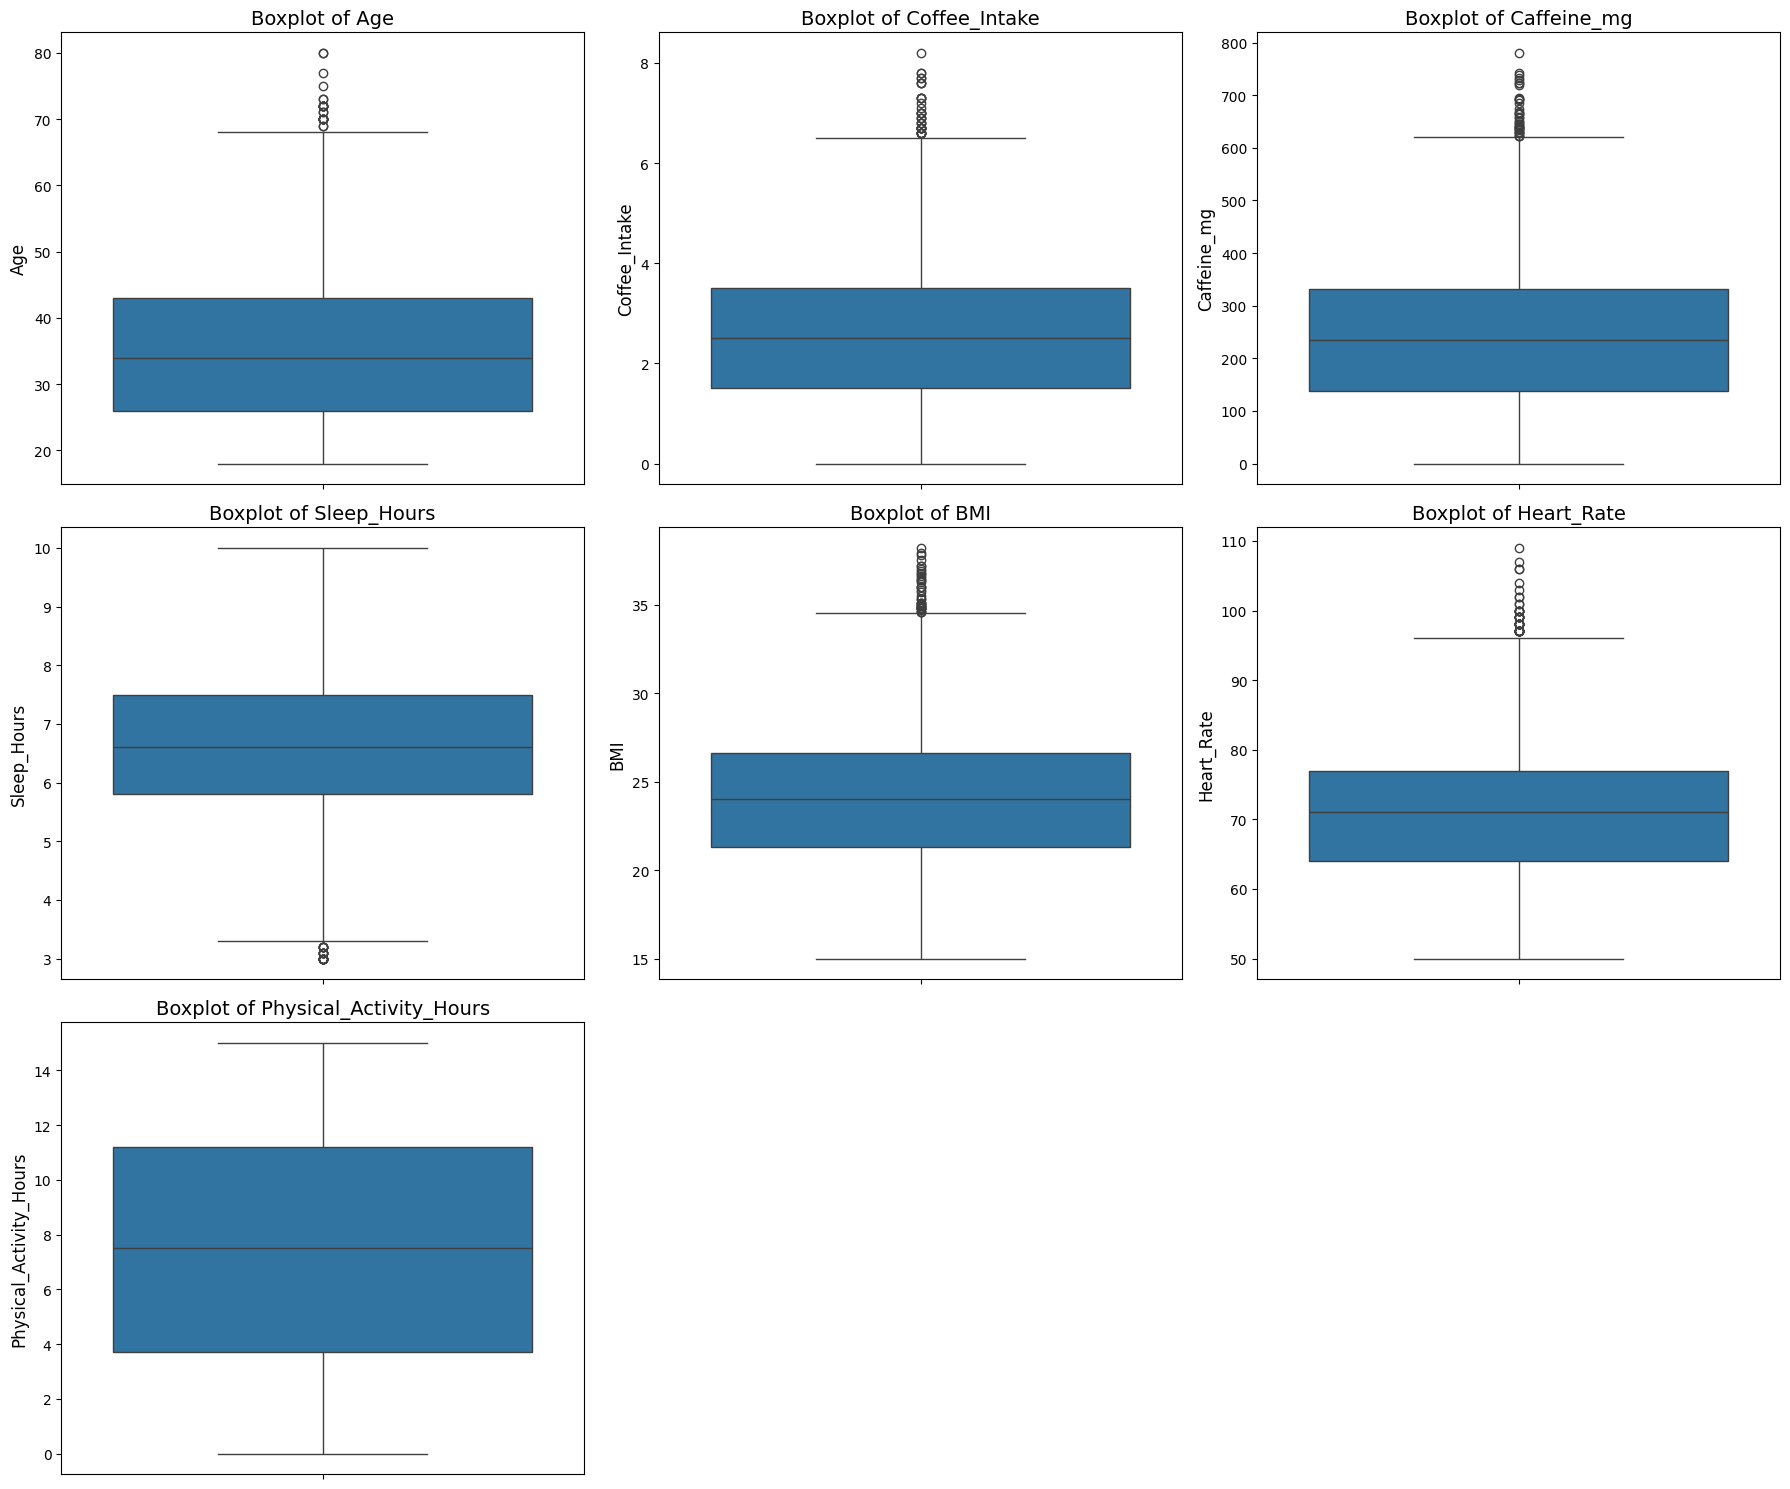

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define the continuous and relevant integer columns for boxplots.
# Boxplots are generally not useful for ID, OHE (0/1), or nominal categorical columns.
numeric_cols = [
    'Age', 
    'Coffee_Intake', 
    'Caffeine_mg', 
    'Sleep_Hours', 
    'BMI', 
    'Heart_Rate', 
    'Physical_Activity_Hours'
]

# 2. Set up the figure and axes for the subplots
n_cols = 3 
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten() # Flatten the array for easy iteration

# 3. Generate a boxplot for each selected numerical column
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=country_df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}', fontsize=14)
    axes[i].set_ylabel(col, fontsize=12)

# 4. Hide any unused subplots
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show() # In your local environment, this will display the plots.

since most of our remainding variables has outliers, our best option for scaling is a ```RobustScaler()``` since it uses IQ ranges to scale each value with the following formula:
$$
X_\text{scaled} = \frac{x_i - Q_1(x)}{Q_3 - Q_1}
$$

## Data Processing Pipeline

After analying all of the available columns, our dataset is ready to be transformed to a ML friendly format. ```ColumnTranformer()``` lets us automatize the preprocessing process, and further on implement this process in a fully developed ML Pipeline

In [ ]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

numeric_cols = ['Age','Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours'] # Variables that have to be scaled

ordinal_categories = ["Stress_Level", "Sleep_Quality", "Health_Issues"] # Variables that have a hierarchical order

one_hot_categories = ["Gender", "Occupation"] # Variables that just need one-hot encoding

passthorugh = ["Smoking","Alcohol_Consumption", "is_asia", "is_america", "is_oceania", "is_europe"] # Variables that are already fine as they are

custom_categories = [["High", "Medium", "Low"], # Stress Level hierarchical order
                     ["Poor", "Fair", "Good", "Excellent"], # Sleep Quality hierarchical order
                     ["Severe", "Moderate", "Mild", "None"]] # Health Issues hierarchical order


ct = ColumnTransformer([
    ("robust_scaler", RobustScaler(), numeric_cols), # scaler
    ("ordinal_encoding", OrdinalEncoder(categories=custom_categories), ordinal_categories), #ordinal encoding
    ("onehot_encoding", OneHotEncoder(handle_unknown="ignore", sparse_output=False), one_hot_categories), #one hot encoding
    ("passthrough", "passthrough", passthorugh) #ignore
],
remainder="passthrough")

transformed_data = ct.fit_transform(country_df)
feature_names = ct.get_feature_names_out() #extract feature names

In [69]:
processed_df = pd.DataFrame(data=transformed_data, columns=feature_names) #This is the final dataframe with all processed variables
processed_df.head()

,robust_scaler__Age,robust_scaler__Coffee_Intake,robust_scaler__Caffeine_mg,robust_scaler__Sleep_Hours,robust_scaler__BMI,robust_scaler__Heart_Rate,robust_scaler__Physical_Activity_Hours,ordinal_encoding__Stress_Level,ordinal_encoding__Sleep_Quality,ordinal_encoding__Health_Issues,...,onehot_encoding__Occupation_Office,onehot_encoding__Occupation_Other,onehot_encoding__Occupation_Service,onehot_encoding__Occupation_Student,passthrough__Smoking,passthrough__Alcohol_Consumption,passthrough__is_asia,passthrough__is_america,passthrough__is_oceania,passthrough__is_europe
0,0.352941,0.5,0.479627,0.529412,0.169811,0.538462,0.933333,2.0,2.0,3.0,...,0.0,1.0,0.0,0.0,False,False,0,0,0,1
1,-0.058824,-0.75,-0.731083,-0.235294,-0.754717,-0.307692,0.466667,2.0,2.0,3.0,...,0.0,0.0,1.0,0.0,False,False,0,0,0,1
2,0.470588,1.4,1.388177,-0.411765,-0.245283,-0.923077,0.493333,1.0,1.0,2.0,...,1.0,0.0,0.0,0.0,False,False,0,1,0,0
3,1.117647,0.05,0.071401,0.411765,0.132075,0.0,-0.12,2.0,2.0,2.0,...,0.0,1.0,0.0,0.0,False,False,0,0,0,1
4,-0.117647,0.3,0.323891,-0.764706,0.018868,0.384615,0.133333,1.0,1.0,2.0,...,0.0,0.0,0.0,1.0,False,True,0,0,0,1


In [72]:
processed_df.to_csv("../data/processed/processed_coffee_data.csv", index=True)